<a href="https://colab.research.google.com/github/hiswordsini/AI_Bootcamp_Project/blob/main/Section2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn.linear_model import LinearRegression, LogisticRegression
import pandas as pd
import pandas_profiling
import numpy as np
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, roc_curve, roc_auc_score, auc, classification_report
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split, GridSearchCV

In [2]:
pip install -U pandas-profiling

     |████████████████████████████████| 256kB 4.8MB/s 
     |████████████████████████████████| 81kB 9.5MB/s 
     |████████████████████████████████| 61kB 7.0MB/s 
     |████████████████████████████████| 3.1MB 39.4MB/s 
     |████████████████████████████████| 1.1MB 38.3MB/s 
     |████████████████████████████████| 645kB 37.7MB/s 
     |████████████████████████████████| 10.1MB 40.1MB/s 
     |████████████████████████████████| 112kB 45.8MB/s 
     |████████████████████████████████| 296kB 28.7MB/s 
  Created wheel for htmlmin: filename=htmlmin-0.1.12-cp37-none-any.whl size=27099 sha256=7d2ed40782bbc45da29ef37860b0811b1c8b0d58a90c99a27b09d17c2e55b4b4
  Stored in directory: /root/.cache/pip/wheels/43/07/ac/7c5a9d708d65247ac1f94066cf1db075540b85716c30255459
  Created wheel for phik: filename=phik-0.11.2-cp37-none-any.whl size=1107437 sha256=f55cfeea0dd421e6be00df52656adfa0ff512044820a5092474fc19e2460d9b8
  Stored in directory: /root/.cache/pip/wheels/c0/a3/b0/f27b1cfe32ea131a3715169132ff6d856

In [2]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
#https://www.kaggle.com/arashnic/hr-analytics-job-change-of-data-scientists
#HR Analytics: Job Change of Data Scientists


train = pd.read_csv('/content/gdrive/MyDrive/Kaggle/DS_Job_Change/aug_train.csv')
test = pd.read_csv('/content/gdrive/MyDrive/Kaggle/DS_Job_Change/aug_test.csv')

#**초기 탐색**

In [4]:
train.shape, test.shape

((19158, 14), (2129, 13))

In [5]:
train.columns

Index(['enrollee_id', 'city', 'city_development_index', 'gender',
       'relevent_experience', 'enrolled_university', 'education_level',
       'major_discipline', 'experience', 'company_size', 'company_type',
       'last_new_job', 'training_hours', 'target'],
      dtype='object')

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

*   ID와 타겟을 제외하고 2가지 특성만 수치형이고 나머지는 모두 범주형 특성이다. 이 중에서 last_new_job와 experience 같은 특성은 수치형으로 변환 할 것이다. 그래서 총 4가지 수치형 특성이 있는 자료가 될 것이다.

In [7]:
train.isnull().sum()

enrollee_id                  0
city                         0
city_development_index       0
gender                    4508
relevent_experience          0
enrolled_university        386
education_level            460
major_discipline          2813
experience                  65
company_size              5938
company_type              6140
last_new_job               423
training_hours               0
target                       0
dtype: int64

*   절반 이상의 특성들이 결측치를 포함하고 있음을 알 수 있다. 각각의 컬럼을 분석하면서 처리해 나갈 것이다.

In [8]:
train.target.value_counts()

0.0    14381
1.0     4777
Name: target, dtype: int64

In [9]:
train.target.value_counts(normalize=True)

0.0    0.750652
1.0    0.249348
Name: target, dtype: float64



*   데이터가 불균형임을 알 수 있다.
*   데이터 불균형 문제 부터 처리할 것이다.



*   target 0: 직장을 옮기지 않는다와 target 1:직장을 옮긴다 간의 차이가 많은 불균형 데이터 셋이므로 데이터가 적은 target 1의 데이터를 늘리는 업샘플링으로 데이터셋의 균형을 맞춰 볼 것입니다.

 

* 그전에 데이터 Leakage 방지를 위해 훈련세트와 검증 세트로 먼저 데이터를 나눈 후 업샘플링을 할 것입니다. 


In [10]:
train, val = train_test_split(train, test_size=0.2, random_state=2)
train.shape, val.shape

((15326, 14), (3832, 14))

훈련 데이터와 검증 데이터에 대해서 업샘플링을 합니다.

In [11]:
#타겟 다수와 소수로 훈련과 검증 세트를 나눕니다.
train_majority = train[train.target == 0]
train_minority = train[train.target == 1]
val_majority = val[val.target == 0]
val_minority = val[val.target == 1]
train_majority.shape, train_minority.shape, val_majority.shape, val_minority.shape

((11513, 14), (3813, 14), (2868, 14), (964, 14))

In [12]:
# Resample function을 사용하여 minority dataframe의 갯수를 majority dataframe의 데이터 갯수만큼 증가시킵니다.
train_minority_upsampled = resample(train_minority, replace=True, n_samples=train_majority.shape[0], random_state=123)
val_minority_upsampled = resample(val_minority, replace=True, n_samples=val_majority.shape[0], random_state=123)
train_minority_upsampled.shape, val_minority_upsampled.shape

((11513, 14), (2868, 14))

In [13]:
# 증가시킨 minority dataframe과 majority dataframe을 다시 합쳐줍니다.
train_upsampled = pd.concat([train_majority, train_minority_upsampled])
val_upsampled = pd.concat([val_majority, val_minority_upsampled])
train_upsampled.shape, val_upsampled.shape

((23026, 14), (5736, 14))

# **범주형 변수(Categorical Variables)**

**City**

In [14]:
train_upsampled['city'].value_counts()

city_103    4889
city_21     4657
city_16     1508
city_114    1294
city_160    1026
            ... 
city_31        3
city_111       3
city_121       2
city_25        2
city_171       1
Name: city, Length: 122, dtype: int64

*   122개의 서로 다른 도시들이 있다.

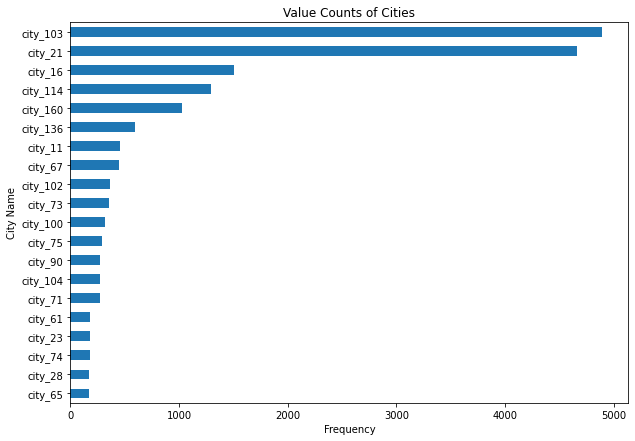

In [15]:
plt.figure(figsize=(10,7))

train_upsampled['city'].value_counts()[:20].sort_values(ascending=True).plot(kind='barh')
plt.title('Value Counts of Cities')
plt.xlabel('Frequency')
plt.ylabel('City Name');



*   상위 20개의 도시 리스트이다. 
*   도시들이 익명화되어 정확히 어느 도시인지를 알 수 없어 중요하지 않다고 판단되어 이 특성은 빼기로 한다. 


**Gender**

In [16]:
train_upsampled['gender'].value_counts()

Male      15550
Female     1467
Other       231
Name: gender, dtype: int64

In [17]:
train_upsampled['gender'].isnull().sum()

5778

In [51]:
train_upsampled['gender'].fillna('Unknown', inplace=True)
val_upsampled['gender'].fillna('Unknown', inplace=True)



*   결측치는 'Unknown'이라는 값을 주기로 한다.



In [19]:
train_upsampled[train_upsampled['gender'] == 'Unknown']

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
2935,189,city_71,0.884,Unknown,Has relevent experience,Part time course,Masters,STEM,13,500-999,Pvt Ltd,1,40,0.0
17164,9109,city_91,0.691,Unknown,Has relevent experience,no_enrollment,Graduate,Other,6,10/49,Funded Startup,1,78,0.0
11097,14780,city_40,0.776,Unknown,No relevent experience,no_enrollment,Masters,STEM,16,50-99,Pvt Ltd,never,59,0.0
10846,5794,city_16,0.910,Unknown,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,12,0.0
14002,28511,city_16,0.910,Unknown,Has relevent experience,no_enrollment,Graduate,STEM,10,10/49,Pvt Ltd,4,12,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2406,12043,city_50,0.896,Unknown,No relevent experience,Full time course,Graduate,STEM,3,NaN,NaN,never,35,1.0
1438,16653,city_70,0.698,Unknown,Has relevent experience,no_enrollment,Graduate,STEM,2,1000-4999,Other,1,140,1.0
7709,21810,city_21,0.624,Unknown,No relevent experience,Full time course,Graduate,STEM,<1,NaN,NaN,never,50,1.0
5229,26983,city_103,0.920,Unknown,Has relevent experience,no_enrollment,Graduate,STEM,6,10000+,Pvt Ltd,1,78,1.0




*   인사이트를 도출하기 위해 Unknown 값으로 된 컬럼들을 확인한다.
*   별다른 특이사항이 발견되지 않는다.



데이터를 시각화 해본다

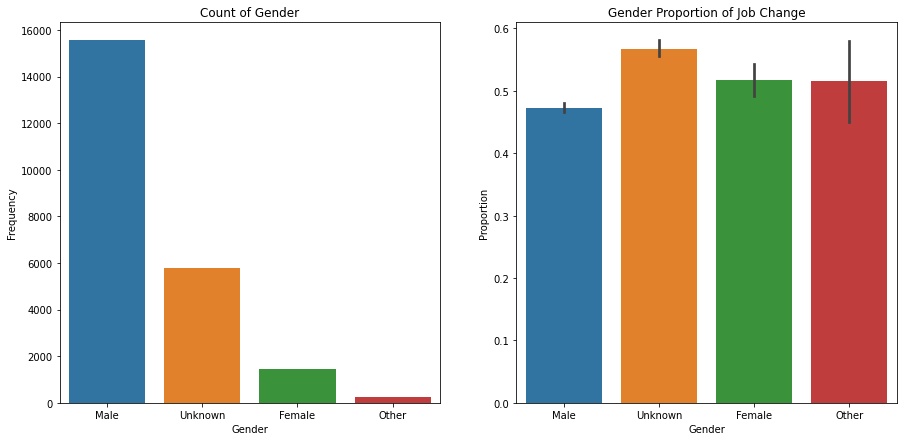

In [20]:
plt.figure(figsize=(15,7))

plt.subplot(121)
sns.countplot(data=train_upsampled, x='gender')
plt.title('Count of Gender')
plt.xlabel('Gender')
plt.ylabel('Frequency');

plt.subplot(122)
sns.barplot(data=train_upsampled, x='gender', y='target')
plt.title('Gender Proportion of Job Change')
plt.xlabel('Gender')
plt.ylabel('Proportion');



*   데이터의 수에는 남자가 현저히 많음을 알 수 있다.
*   이직을 하는 성별의 비율은 Unknown이 가장 많고 여자와 그외의 성별이 비슷하고 남자가 상대적으로 비율이 작다.



좀 더 자세히 들여다 보자

성별과 타겟의 개수를 비교하는 테이블을 만든다

In [21]:
gender_table = pd.crosstab(train_upsampled['gender'], train_upsampled['target'])
gender_table

target,0.0,1.0
gender,,
Female,707,760
Male,8194,7356
Other,112,119
Unknown,2500,3278




*   남자가 여자 보다 열배 넘게 데이터를 차지하고 있다.



각 성별별로 이직하는 비율을 나타낸 테이블을 만들어본다.

In [22]:
pd.crosstab(train_upsampled['gender'], train_upsampled['target'], normalize='index')

target,0.0,1.0
gender,,
Female,0.481936,0.518064
Male,0.526945,0.473055
Other,0.484848,0.515152
Unknown,0.432676,0.567324




*   여자가 남자보다 이직하는 비율이 더 많음을 알 수 있다.
*   결측(Unknown) 데이터에서 이직하는 비율이 가장 많이 나타났음을 알 수 있다



성별이 이직 여부를 예측하는 특성으로 사용될지 판가름하기 위해 통계적 유의미함을 알아볼 수 있는 카이 제곱 테스트를 해본다.

In [23]:
stat, p, dof, expected = chi2_contingency(gender_table)

# interpret p-value 
alpha = 0.05
print("p value is " + str(p)) 
if p <= alpha: 
    print('Dependent (reject H0)') 
else: 
    print('Independent (H0 holds true)') 

p value is 9.546110020821455e-33
Dependent (reject H0)




*   p value 가 0.05 보다 현저히 작으므로 귀무 가설을 기각한다. (성별과 타겟 값 사이의 관계는 독립적이지 않다.(종속적이다))
*   성별과 타겟 값 사이에 유의미한 종속 관계가 있음을 의미하므로 이 특성을 모델을 만드는데 사용하기로 한다.


**Relevant Experience**

In [24]:
train_upsampled['relevent_experience'].value_counts()

Has relevent experience    15779
No relevent experience      7247
Name: relevent_experience, dtype: int64

* 관련 경험이 있는 경우가 없는 경우의 두배를 넘는다. 



간단하게 바꾸고 인코딩을 위해서 Has relevant experience 를 1로 바꾸고 No relevant experience를 0으로 바꾼다.

In [52]:
train_upsampled['relevent_experience'] = train_upsampled['relevent_experience'].replace('Has relevent experience', 1)
train_upsampled['relevent_experience'] = train_upsampled['relevent_experience'].replace('No relevent experience', 0)
val_upsampled['relevent_experience'] = val_upsampled['relevent_experience'].replace('Has relevent experience', 1)
val_upsampled['relevent_experience'] = val_upsampled['relevent_experience'].replace('No relevent experience', 0)

비율과 개수를 시각화 한다.

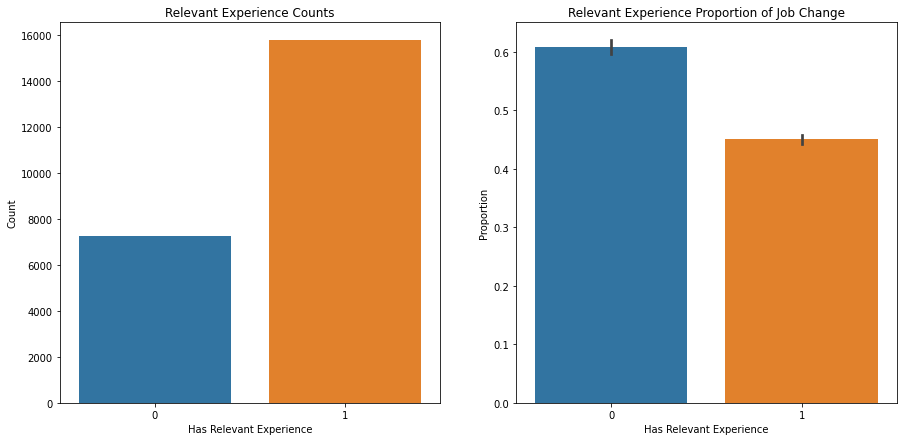

In [26]:
plt.figure(figsize=(15,7))

plt.subplot(121)
sns.countplot(data=train_upsampled, x='relevent_experience')
plt.title('Relevant Experience Counts')
plt.xlabel('Has Relevant Experience')
plt.ylabel('Count');

plt.subplot(122)
sns.barplot(data=train_upsampled, x='relevent_experience', y='target')
plt.title('Relevant Experience Proportion of Job Change')
plt.xlabel('Has Relevant Experience')
plt.ylabel('Proportion');



*   관련 경험이 있는 사람이 없는 사람의 2배 이상이다
*   이직 여부는 관련 경험이 없는 사람이 더 많다는 것을 알 수 있다.



이 차이를 분명히 하기 위해 카이 제곱 테스트를 한다

In [27]:
exp_table = pd.crosstab(train_upsampled['relevent_experience'], train_upsampled['target'])
exp_table

target,0.0,1.0
relevent_experience,,
0,2839,4408
1,8674,7105


In [28]:
pd.crosstab(train_upsampled['relevent_experience'], train_upsampled['target'], normalize = 'index')

target,0.0,1.0
relevent_experience,,
0,0.391748,0.608252
1,0.549718,0.450282


In [29]:
stat, p, dof, expected = chi2_contingency(exp_table)

# interpret p-value 
alpha = 0.05
print("p value is " + str(p)) 
if p <= alpha: 
    print('Dependent (reject H0)') 
else: 
    print('Independent (H0 holds true)') 

p value is 1.1196808673160488e-109
Dependent (reject H0)




*   p value가 0.05 보다 현저히 작음을 알 수 있다. 따라서 relevent experience도 모델에 추가하기 좋은 특성으로 생각된다.



**Enrolled University**


*   Enrolled University는 지원자가 대학에 풀타임으로 등록되어 있는지 아니면 파트 타임으로 등록되어 있는지 아니면 등록되어 있지 않은지 나타낸다

In [30]:
train_upsampled['enrolled_university'].value_counts()

no_enrollment       15766
Full time course     5350
Part time course     1397
Name: enrolled_university, dtype: int64



*   대부분의 사람들이 대학에 등록되어 있지 않다




In [31]:
train_upsampled['enrolled_university'].isnull().sum()

513

결측치를 'Unknown'으로 채우기로 한다.

In [53]:
train_upsampled['enrolled_university'].fillna('Unknown', inplace=True)
val_upsampled['enrolled_university'].fillna('Unknown', inplace=True)

In [33]:
train_upsampled['enrolled_university'].value_counts()

no_enrollment       15766
Full time course     5350
Part time course     1397
Unknown               513
Name: enrolled_university, dtype: int64

시각화 한다

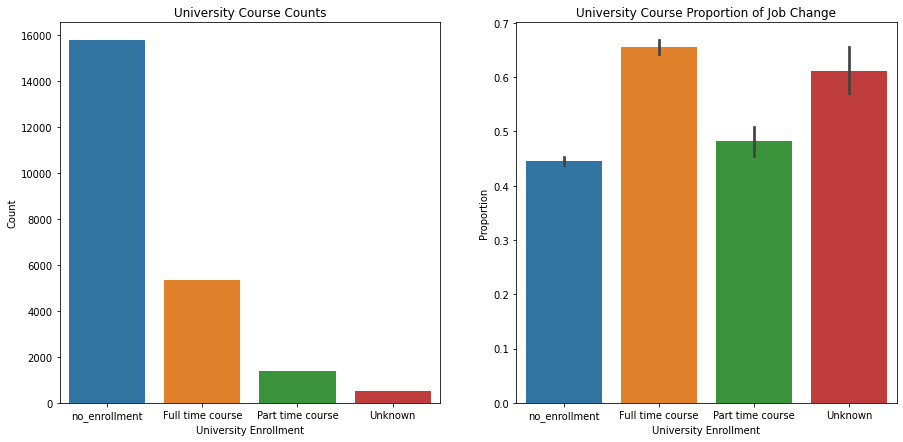

In [34]:
plt.figure(figsize=(15,7))

plt.subplot(121)
sns.countplot(data=train_upsampled, x='enrolled_university')
plt.title('University Course Counts')
plt.xlabel('University Enrollment')
plt.ylabel('Count');


plt.subplot(122)
sns.barplot(data=train_upsampled, x='enrolled_university', y='target')
plt.title('University Course Proportion of Job Change')
plt.xlabel('University Enrollment')
plt.ylabel('Proportion');



*   대부분의 사람들이 대학에 등록되어 있지 않고 그러한 사람들이 이직 비율이 가장 작았다.
*   풀 타임으로 대학에 등록되어 있는 사람들이 이직 비율이 가장 많았고 그 다음이 결측 데이터의 사람들이었다.



카이 제곱 테스트를 한다.

In [35]:
enrolled_table = pd.crosstab(train_upsampled['enrolled_university'],train_upsampled['target'])
pd.crosstab(train_upsampled['enrolled_university'],train_upsampled['target'], normalize = 'index')

target,0.0,1.0
enrolled_university,,
Full time course,0.344673,0.655327
Part time course,0.518253,0.481747
Unknown,0.387914,0.612086
no_enrollment,0.554738,0.445262


In [36]:
stat, p, dof, expected = chi2_contingency(enrolled_table)

# interpret p-value 
alpha = 0.05
print("p value is " + str(p)) 
if p <= alpha: 
    print('Dependent (reject H0)') 
else: 
    print('Independent (H0 holds true)') 

p value is 1.537606806946799e-158
Dependent (reject H0)




*   University Enrollment 도 모델에 포함할 좋은 특성이다.


**Education Level**

학력은 (Ph.D, Masters, Graduate, HIgh School, Primary School) 값으로 구분된다.

In [37]:
train_upsampled['education_level'].value_counts()

Graduate          14367
Masters            5088
High School        2280
Phd                 441
Primary School      310
Name: education_level, dtype: int64



*   대부분의 사람들이 대졸(Graduate)이다.



In [38]:
train_upsampled['education_level'].isnull().sum()

540

결측치를 'Unknown'으로 대체한다.

In [54]:
train_upsampled['education_level'].fillna('Unknown', inplace=True)
val_upsampled['education_level'].fillna('Unknown', inplace=True)

In [40]:
train_upsampled['education_level'].value_counts()

Graduate          14367
Masters            5088
High School        2280
Unknown             540
Phd                 441
Primary School      310
Name: education_level, dtype: int64

시각화 한다.

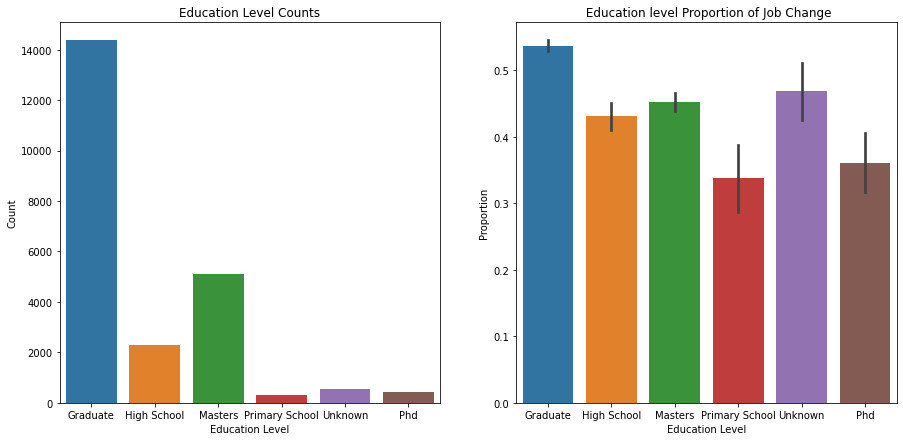

In [41]:
plt.figure(figsize=(15,7))

plt.subplot(121)
sns.countplot(data=train_upsampled, x='education_level')
plt.title('Education Level Counts')
plt.xlabel('Education Level')
plt.ylabel('Count');


plt.subplot(122)
sns.barplot(data=train_upsampled, x='education_level', y='target')
plt.title(' Education level Proportion of Job Change')
plt.xlabel('Education Level')
plt.ylabel('Proportion');



*   대졸자는 다른 학력을 모두 합친 것보다 월등히 많으나 이직 비율에서는 다른 학력에 비해 약간 높은 비율을 보임을 알 수 있다.



In [42]:
edu_table = pd.crosstab(train_upsampled['education_level'],train_upsampled['target'])

In [43]:
pd.crosstab(train_upsampled['education_level'],train_upsampled['target'], normalize = 'index')

target,0.0,1.0
education_level,,
Graduate,0.463423,0.536577
High School,0.568860,0.431140
Masters,0.547170,0.452830
Phd,0.639456,0.360544
Primary School,0.661290,0.338710
Unknown,0.531481,0.468519


카이 제곱 테스트

In [44]:
stat, p, dof, expected = chi2_contingency(edu_table)

# interpret p-value 
alpha = 0.05
print("p value is " + str(p)) 
if p <= alpha: 
    print('Dependent (reject H0)') 
else: 
    print('Independent (H0 holds true)') 

p value is 1.4021315190662944e-48
Dependent (reject H0)




*   Education Level도 모델에 포함한다.

**Major Discipline**

전공계열은 (STEM, Humanities, Other, Business Degree, Arts, No Major)로 구분된다.

In [45]:
train_upsampled['major_discipline'].value_counts()

STEM               17669
Humanities           743
Other                467
Business Degree      387
Arts                 316
No Major             267
Name: major_discipline, dtype: int64



*   전공은 STEM(과학,기술,공학,수학)이 월등히 많은 수를 차지함을 알 수 있다.



In [46]:
train_upsampled['major_discipline'].isnull().sum()

3177

결측 데이터는 'Unknown'으로 채운다.

In [55]:
train_upsampled['major_discipline'].fillna('Unknown', inplace=True)
val_upsampled['major_discipline'].fillna('Unknown', inplace=True)

시각화

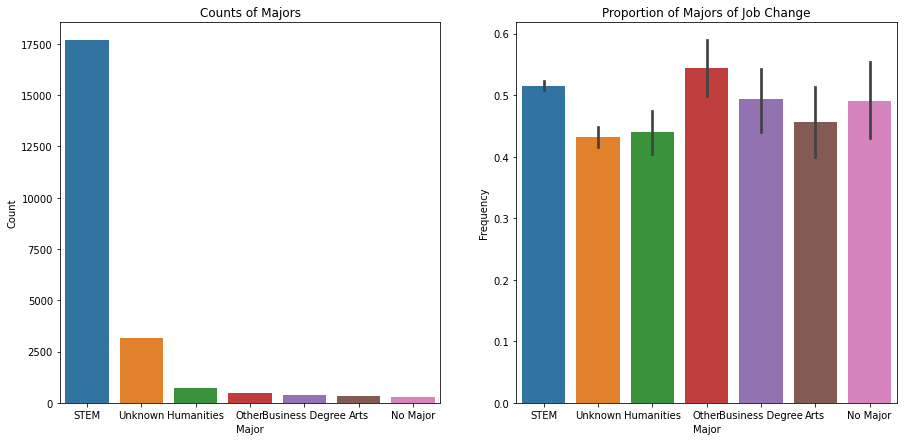

In [48]:
plt.figure(figsize=(15,7))

plt.subplot(121)
sns.countplot(data=train_upsampled, x='major_discipline')
plt.title('Counts of Majors')
plt.xlabel('Major')
plt.ylabel('Count');

plt.subplot(122)
sns.barplot(data=train_upsampled, x='major_discipline', y='target')
plt.title('Proportion of Majors of Job Change')
plt.xlabel('Major')
plt.ylabel('Frequency');



*   STEM degree가 숫자면에서는 월등히 많음을 알 수 있다.
*   이직 비율은 전공 계열들이 비슷비슷 함을 알 수 있다.



In [49]:
major_table = pd.crosstab(train_upsampled['major_discipline'],train_upsampled['target'])

In [50]:
pd.crosstab(train_upsampled['major_discipline'],train_upsampled['target'], normalize = 'index')

target,0.0,1.0
major_discipline,,
Arts,0.544304,0.455696
Business Degree,0.506460,0.493540
Humanities,0.559892,0.440108
No Major,0.509363,0.490637
Other,0.456103,0.543897
STEM,0.485257,0.514743
Unknown,0.568461,0.431539


카이 제곱 테스트

In [56]:
stat, p, dof, expected = chi2_contingency(major_table)

# interpret p-value 
alpha = 0.05
print("p value is " + str(p)) 
if p <= alpha: 
    print('Dependent (reject H0)') 
else: 
    print('Independent (H0 holds true)') 

p value is 1.2664591955662902e-17
Dependent (reject H0)



*   Major Discipline 특성도 모델에 포함한다.


**Company Size**

회사 규모는 (<10, 10/49, 50-99, 100-500, 500-999, 1000-4999, 5000-9999, 10000+) 의 값을 가진다

In [57]:
train_upsampled['company_size'].value_counts()

50-99        3357
100-500      2657
10000+       2231
10/49        1737
<10          1395
1000-4999    1379
500-999       944
5000-9999     598
Name: company_size, dtype: int64



*   50-99명의 규모가 가장 많다.



In [58]:
train_upsampled['company_size'].isnull().sum()

8728

결측치를 'Unknown'으로 대체한다.

In [59]:
train_upsampled['company_size'].fillna('Unknown', inplace=True)
val_upsampled['company_size'].fillna('Unknown', inplace=True)

시각화

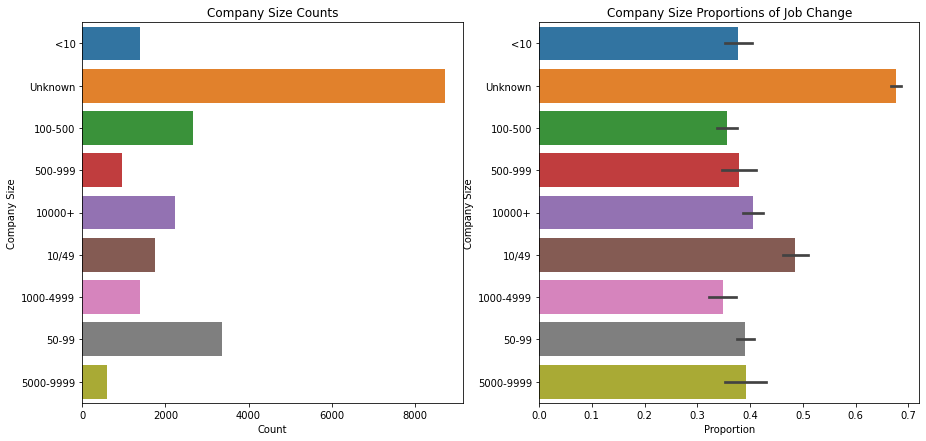

In [60]:
plt.figure(figsize=(15,7))

plt.subplot(121)
sns.countplot(data=train_upsampled, y='company_size')
plt.title('Company Size Counts')
plt.xlabel('Count')
plt.ylabel('Company Size');

plt.subplot(122)
sns.barplot(data=train_upsampled, y='company_size', x='target')
plt.title('Company Size Proportions of Job Change')
plt.xlabel('Proportion')
plt.ylabel('Company Size');



*   결측 데이터의 사람들이 가장 많음을 알 수 있다.
*   이직 비율도 결측 데이터의 사람들이 가장 많음을 알 수 있다.



In [61]:
comp_size_table = pd.crosstab(train_upsampled['company_size'],train_upsampled['target'])
pd.crosstab(train_upsampled['company_size'],train_upsampled['target'], normalize = 'index')

target,0.0,1.0
company_size,,
10/49,0.514105,0.485895
100-500,0.643583,0.356417
1000-4999,0.651922,0.348078
10000+,0.594801,0.405199
50-99,0.609771,0.390229
500-999,0.620763,0.379237
5000-9999,0.607023,0.392977
<10,0.622222,0.377778
Unknown,0.323098,0.676902


카이 제곱 테스트

In [62]:
stat, p, dof, expected = chi2_contingency(comp_size_table)

# interpret p-value 
alpha = 0.05
print("p value is " + str(p)) 
if p <= alpha: 
    print('Dependent (reject H0)') 
else: 
    print('Independent (H0 holds true)') 

p value is 0.0
Dependent (reject H0)




*   Company Size도 모델에 포함한다.



**Company Type**

회사 타입은 (Pvt Ltd, Funded Startup, Public Sector, Early Stage Startup, NGO, Other)의 값을 가진다.

In [63]:
train_upsampled['company_type'].value_counts()

Pvt Ltd                10695
Public Sector           1094
Funded Startup           999
Early Stage Startup      737
NGO                      555
Other                    155
Name: company_type, dtype: int64



*   개인 회사가 가장 많음을 알 수 있다.



In [64]:
train_upsampled['company_type'].isnull().sum()

8791

결측치를 'Unknown'으로 대체한다.

In [65]:
train_upsampled['company_type'].fillna('Unknown', inplace=True)
val_upsampled['company_type'].fillna('Unknown', inplace=True)

시각화

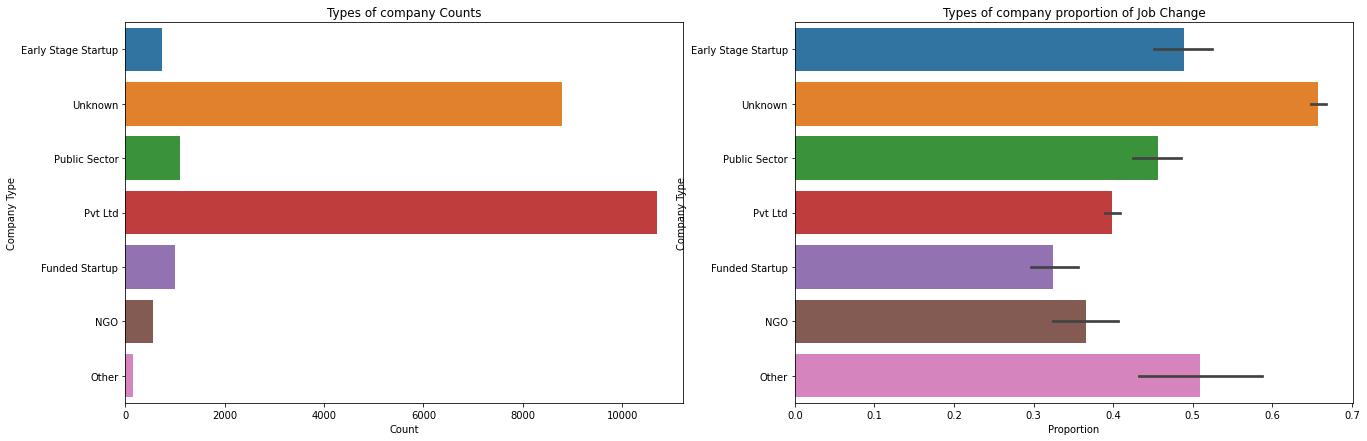

In [66]:
plt.figure(figsize=(22,7))

plt.subplot(121)
sns.countplot(data=train_upsampled, y='company_type')
plt.title('Types of company Counts')
plt.xlabel('Count')
plt.ylabel('Company Type');

plt.subplot(122)
sns.barplot(data=train_upsampled, y='company_type', x='target')
plt.title('Types of company proportion of Job Change')
plt.xlabel('Proportion')
plt.ylabel('Company Type');



*   개인회사(Pvt Ltd)가 가장 많은 수를 차지하고 그 다음 결측 데이터의 회사들이 많음을 알 수 있다.
*   이직 비율은 결측 데이터의 회사들이 가장 많음을 알 수 있다.



In [67]:
comp_type_table = pd.crosstab(train_upsampled['company_type'],train_upsampled['target'])
pd.crosstab(train_upsampled['company_type'],train_upsampled['target'], normalize = 'index')

target,0.0,1.0
company_type,,
Early Stage Startup,0.511533,0.488467
Funded Startup,0.675676,0.324324
NGO,0.634234,0.365766
Other,0.490323,0.509677
Public Sector,0.543876,0.456124
Pvt Ltd,0.601122,0.398878
Unknown,0.342282,0.657718


카이 제곱 테스트

In [68]:
stat, p, dof, expected = chi2_contingency(comp_type_table)

# interpret p-value 
alpha = 0.05
print("p value is " + str(p)) 
if p <= alpha: 
    print('Dependent (reject H0)') 
else: 
    print('Independent (H0 holds true)') 

p value is 0.0
Dependent (reject H0)




*   Company Type도 모델에 포함한다.


# **연속형 변수(Continuous Variables)**

**City Development Index**

In [69]:
train_upsampled['city_development_index'].describe()

count    23026.000000
mean         0.804492
std          0.134329
min          0.448000
25%          0.624000
50%          0.890000
75%          0.920000
max          0.949000
Name: city_development_index, dtype: float64

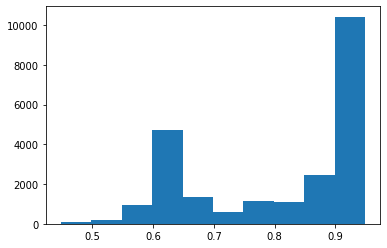

In [70]:
plt.hist(data=train_upsampled, x='city_development_index');



*   대부분의 도시개발지수가 0.9보다 높다



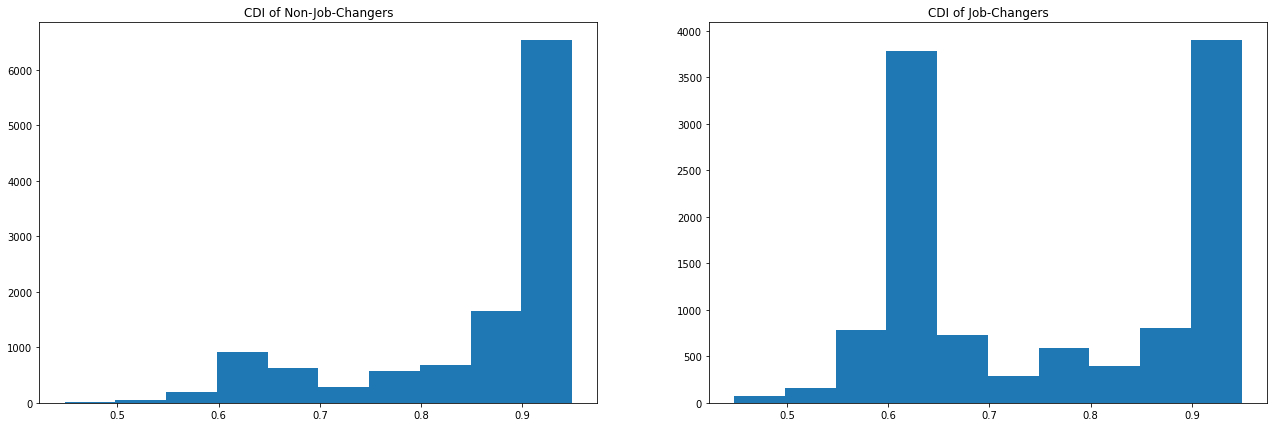

In [71]:
plt.figure(figsize=(22,7))

plt.subplot(121)
plt.title('CDI of Non-Job-Changers')
plt.hist(data=train_upsampled[train_upsampled['target'] == 0], x='city_development_index')


plt.subplot(122)
plt.title('CDI of Job-Changers')
plt.hist(data=train_upsampled[train_upsampled['target'] == 1], x='city_development_index');



*   이직을 하지 않는 쪽은 도시개발지수가 전체 분포와 비슷하다.
*   이직을 하는 쪽은 도시개발지수가 0.6과 0.9 주위에서 많은 수를 기록했다.



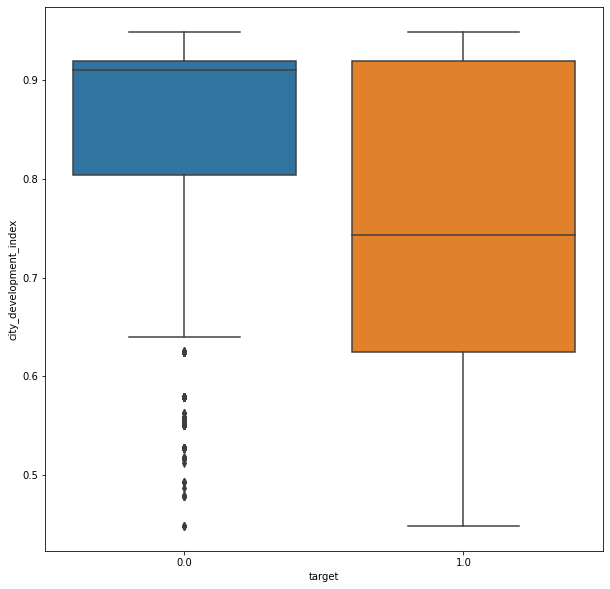

In [72]:
plt.figure(figsize=(10,10))
sns.boxplot(data=train_upsampled, x='target', y='city_development_index')

Kruskal Wallis Test

두 그룹 사이에 통계적으로 유의미한 차이가 있는지 알아보기 위해 연속형 변수(Continuous Variable)에 사용되는 Kruskal Wallis Test를 시행해 본다.

In [73]:
no_change_df = train_upsampled[train_upsampled['target'] == 0]
change_df =  train_upsampled[train_upsampled['target'] == 1]

In [74]:
stats.kruskal(no_change_df['city_development_index'], change_df['city_development_index'])

KruskalResult(statistic=2378.1398154123535, pvalue=0.0)

*   p value 가 0으로 매우 작다. 통계적으로 매우 유의미한 특성으로 모델에 포함한다.

**Experience**

경험은 년수를 나타낸 것으로 1 보다 작거나 부터 20보다 큰 값까지 있다.

In [75]:
train_upsampled['experience'].value_counts()

>20    3457
4      1846
5      1800
3      1795
6      1550
2      1522
7      1292
9      1151
10     1132
8       913
1       894
11      781
<1      736
15      730
14      687
16      551
12      531
13      465
17      360
19      303
18      279
20      180
Name: experience, dtype: int64

'>20'을 21로 <1을 0으로 바꾼다. 이렇게 하여 일관된 데이터 타입을 갖고 모델이 읽어 들일 수 있는 값을 갖게 된다.

In [76]:
train_upsampled['experience'].isnull().sum()

71

결측치는 데이터에서 랜덤하게 뽑아서 채우도록 한다.


In [77]:
np.random.seed(123) #랜덤한 값이 매번 같은 값을 가지도록 랜덤 씨드를 지정해준다.
train_upsampled['experience'] = train_upsampled['experience'].replace('>20', 21)
train_upsampled['experience'] = train_upsampled['experience'].replace('<1', 0)
train_upsampled['experience'] = train_upsampled['experience'].fillna(np.random.choice(train_upsampled['experience']))

수치형 데이터 타입이 되도록 데이터 타임을 float로 바꾼다.

In [78]:
train_upsampled['experience'] = train_upsampled['experience'].astype('float64')

데이터를 살펴본다

In [79]:
train_upsampled['experience'].describe()

count    23026.000000
mean         9.415704
std          6.692446
min          0.000000
25%          4.000000
50%          8.000000
75%         15.000000
max         21.000000
Name: experience, dtype: float64

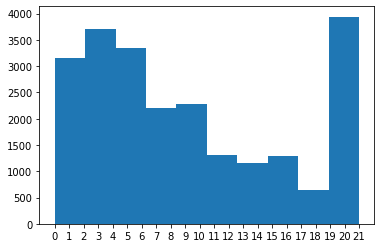

In [82]:
plt.xticks(np.arange(0, 22))
plt.hist(data=train_upsampled, x='experience');



*   20년 이상과 0~6년 사이의 경험이 가장 많음을 알 수 있다.



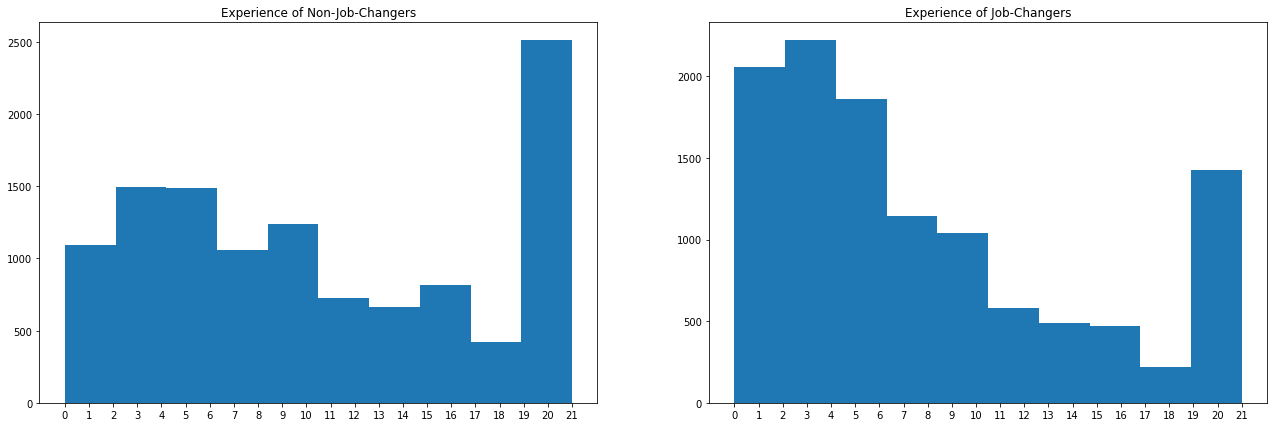

In [83]:
plt.figure(figsize=(22,7))

plt.subplot(121)
plt.title('Experience of Non-Job-Changers')
plt.xticks(np.arange(0, 22))
plt.hist(data=train_upsampled[train_upsampled['target'] == 0], x='experience')

plt.subplot(122)
plt.title('Experience of Job-Changers')
plt.xticks(np.arange(0, 22))
plt.hist(data=train_upsampled[train_upsampled['target'] == 1], x='experience');



*   이직자들 중 0~6년사이의 경험자가 가장 많고 그리고 20년 이상이 많다.
*   비이직자들중에서는 20년 이상이 가장 많음을 알 수 있다.



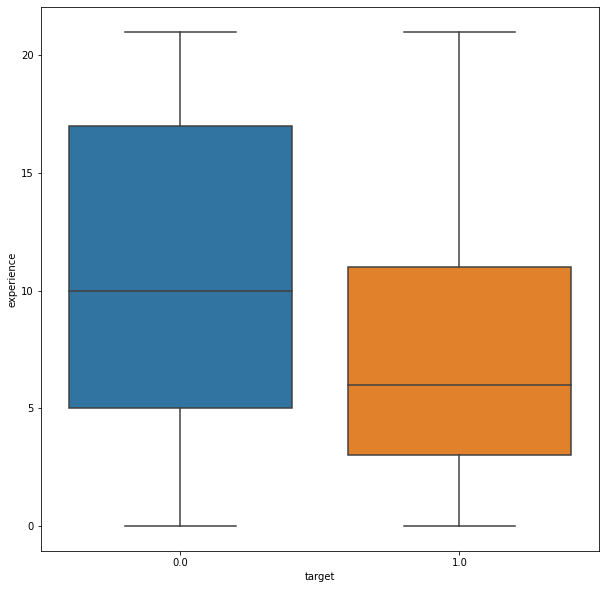

In [84]:
plt.figure(figsize=(10,10))
sns.boxplot(data=train_upsampled, x='target', y='experience')



*   경험이 적을 수록 이직할 확률이 높은듯하다.



Kruskal Wallis Test

In [85]:
no_change_df = train_upsampled[train_upsampled['target'] == 0]
change_df =  train_upsampled[train_upsampled['target'] == 1]

stats.kruskal(no_change_df['experience'], change_df['experience'])

KruskalResult(statistic=996.7544855279108, pvalue=9.11433322223398e-219)

*   p-value가 매우 낮으므로 통계적으로 유의미한 특성임을 알 수 있다. Experience도 모델에 포함한다.

**Last New Job**

이전 직장과 현재 직장 사이의 년수의 차를 나타낸다.

In [86]:
train_upsampled['last_new_job'].value_counts()

1        9892
>4       3589
2        3442
never    3139
4        1210
3        1200
Name: last_new_job, dtype: int64

In [ ]:
train.profile_report()

In [ ]:
test.profile_report()

In [6]:
y_test = np.load('/content/gdrive/MyDrive/Kaggle/DS_Job_Change/jobchange_test_target_values.npy', encoding='bytes')

In [7]:
len(y_test)

2129

In [8]:
#결측치 처리
#불균형 데이터 처리

In [9]:
train.isnull().sum()

enrollee_id                  0
city                         0
city_development_index       0
gender                    4508
relevent_experience          0
enrolled_university        386
education_level            460
major_discipline          2813
experience                  65
company_size              5938
company_type              6140
last_new_job               423
training_hours               0
target                       0
dtype: int64

In [10]:
train.dtypes

enrollee_id                 int64
city                       object
city_development_index    float64
gender                     object
relevent_experience        object
enrolled_university        object
education_level            object
major_discipline           object
experience                 object
company_size               object
company_type               object
last_new_job               object
training_hours              int64
target                    float64
dtype: object

In [12]:
train.fillna("Unknown", inplace=True) #결측치를 모두 Unknown 이라는 값으로 대체하였다.

In [13]:
train.isnull().sum()

enrollee_id               0
city                      0
city_development_index    0
gender                    0
relevent_experience       0
enrolled_university       0
education_level           0
major_discipline          0
experience                0
company_size              0
company_type              0
last_new_job              0
training_hours            0
target                    0
dtype: int64

In [14]:
#city 특성이 high cardinality인데 어짜피 어떤 도시인지 모르므로 중요하지 않다고 생각되어 드랍한다.
y_train = train.target
X_train = train.drop(['target','city'], axis=1)

pipe = make_pipeline(
    OrdinalEncoder(), 
    LogisticRegression()
)

pipe.fit(X_train, y_train)

pred_y_0 = pipe.predict(X_train)
print(np.unique(pred_y_0))

print(accuracy_score(pred_y_0, y_train))
#train 데이터로 로지스틱 리그레션 모델을 돌렸을 때 accuracy 값이 0.767 나왔다.

[0. 1.]
0.7671468838083307


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [15]:
def evaluate(model, X, y):
    predictions = model.predict(X)
    accuracy = accuracy_score(predictions, y)
    tn, fp, fn, tp = confusion_matrix(y, predictions).ravel()
    sensitivity = tp / (tp+fn)
    specificity = tn / (tn+fp)
    auc = roc_auc_score(y, predictions)
    
    print("AUC: ", auc)
    print("Sensitivity: ", round(sensitivity,2)) #1의 값을 예측한 정도
    print("Specificity: ", round(specificity,2)) #0의 값을 예측한 정도

    return round(accuracy,2)


In [16]:
evaluate(pipe, X_train, y_train)

AUC:  0.6033946574048397
Sensitivity:  0.28
Specificity:  0.93


0.77

In [19]:
train.target.value_counts(normalize=True)

0.0    0.750652
1.0    0.249348
Name: target, dtype: float64

In [ ]:
df_minority_upsampled.profile_report()

In [ ]:
df_upsampled.profile_report()

In [64]:
# Resampel function으로 인해 데이터가 balanced 된것을 확인합니다. 
df_upsampled.target.value_counts()

1.0    14381
0.0    14381
Name: target, dtype: int64

In [66]:
y = df_upsampled.target
X = df_upsampled.drop(['target','city'], axis=1)
pipe_up = make_pipeline(
    OrdinalEncoder(), 
    LogisticRegression()
)
pipe_up.fit(X, y)

pred_y_1 = pipe_up.predict(X)
print(np.unique(pred_y_1))
print(accuracy_score(y, pred_y_1))

[0. 1.]
0.702141714762534


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [55]:
evaluate(pipe, X_train, y_train)

AUC:  0.6033946574048397
Sensitivity:  0.28
Specificity:  0.93


0.77

In [67]:
evaluate(pipe_up, X, y)

AUC:  0.702141714762534
Sensitivity:  0.69
Specificity:  0.71


0.7

* 데이터 불균형을 해결함으로써 1의값을 예측하는 정도와 0의 값을 예측하는 정도가 비슷하게 맞춰진 것을 알 수 있다.
* AUC 값도 0.6에 비해 더 높은 0.7이라는 결과가 나왔다.

,enrollee_id,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
1,29725,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47
2,11561,0.624,Unknown,No relevent experience,Full time course,Graduate,STEM,5,Unknown,Unknown,never,83
4,666,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8
6,28806,0.920,Male,Has relevent experience,no_enrollment,High School,Unknown,5,50-99,Funded Startup,1,24
9,699,0.920,Unknown,Has relevent experience,no_enrollment,Graduate,STEM,17,10000+,Pvt Ltd,>4,123
...,...,...,...,...,...,...,...,...,...,...,...,...
9522,8952,0.624,Male,Has relevent experience,Full time course,Graduate,STEM,4,50-99,Pvt Ltd,1,23
4315,13109,0.920,Male,Has relevent experience,Full time course,Graduate,STEM,4,10/49,Pvt Ltd,1,40
7,402,0.762,Male,Has relevent experience,no_enrollment,Graduate,STEM,13,<10,Pvt Ltd,>4,18
2414,21890,0.624,Male,Has relevent experience,no_enrollment,Graduate,STEM,4,Unknown,Unknown,1,68
